In [1]:
import pandas as pd

# Read CSV
df = pd.read_csv('./Dataset/Channel_Logs/channel2Logs.csv')

# Split in half without shuffling
mid_index = len(df) // 2
first_half = df.iloc[:mid_index]
second_half = df.iloc[mid_index:]

# Save to new CSV files
first_half.to_csv('./Dataset/Channel_Logs/channel2Logs.csv_part1.csv', index=False)
second_half.to_csv('./Dataset/Channel_Logs/channel2Logs.csv_part2.csv', index=False)


KeyboardInterrupt: 

In [ ]:
# Changes AWS to True if on SageMaker Instance and set S3 BUCKET and Key accordingly
AWS = False
REGION = 'eu-west-1'
BUCKET = 'ml-can-ids-logs'
s3 = None
from importlib import reload
import pandas as pd
import numpy as np
import os
import feature_selection
from feature_selection import feature_selection_preparation
from sklearn.ensemble import RandomForestClassifier

reload(feature_selection)

# Adjust pandas display optionss
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No wrapping, long rows won't be cut off
pd.set_option('display.max_colwidth', None)  # Show full column content (especially useful for long strings)


# Remove this after testing/debugging
SEED = 42
np.random.seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  



In [ ]:
if AWS:
    s3 = get_s3_client(REGION, BUCKET, True)
    
    # Get S3 Object 
    channel2logs = s3.get_object(Bucket = BUCKET, Key= 'channel2Logs.csv')
    dos_attack_channel2 = s3.get_object(Bucket = BUCKET, Key= 'dos_attack_channel2.csv')
    replay_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'replay_attack_channel2.csv') 
    spoofing_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'new_spoofing_attack_channel2.csv') 

    channel2logs = channel2logs['Body'].read().decode('utf-8')
    dos_attack_channel2 = dos_attack_channel2['Body'].read().decode('utf-8')
    replay_attack_channel2 = replay_attack_channel2['Body'].read().decode('utf-8')
    spoofing_attack_channel2 = spoofing_attack_channel2['Body'].read().decode('utf-8')

    # Get Content
    channel2logs = StringIO(channel2logs)
    dos_attack_channel2 = StringIO(dos_attack_channel2)
    replay_attack_channel2 = StringIO(replay_attack_channel2)
    spoofing_attack_channel2 = StringIO(spoofing_attack_channel2)

    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = dos_attack_channel2 # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = replay_attack_channel2 # Replay on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = spoofing_attack_channel2 # Spoofing on channel 2 (Red Channel)

    # Unprocessed Channel Data
    preprocessed_normal_channel2_csv_path = channel2logs # Red Channel
    preprocessed_normal_channel4_csv_path = "" # Yellow Channel
    preprocessed_normal_channel5_csv_path = "" # Green Channel

    # Current best model
    best_model_path = ""
else:
    # Unprocessed Normal and Attack Data
    preprocessed_normal_csv_path = './Dataset/Tw22206_L003_with_ecu_channel.csv'  # Normal Unprocessed
    preprocessed_DoS_csv_path = './Dataset/Attack_Logs/dos_attack.csv'  # Dos Unprocessed
    preprocessed_Fuzzy_csv_path = './Dataset/Attack_Logs/fuzzy_attack.csv'  # Fuzzy Unprocessed
    preprocessed_Replay_csv_path = './Dataset/Attack_Logs/replay_attack.csv'  # Replay Unprocessed - Test
    preprocessed_Spoofing_csv_path = './Dataset/Attack_Logs/spoofing_attack.csv'  # Spoofing Unprocessed
    preprocessed_Suspension_csv_path = './Dataset/Attack_Logs/suspension_attack.csv'  # Suspension Unprocessed - Hardest Attack Type


    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = './Dataset/Attack_Logs/dos_attack_channel2.csv'  # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = './Dataset/Attack_Logs/replay_attack_channel2.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_Suspension_channel2_csv_path = './Dataset/Attack_Logs/suspension_attack_channel2.csv'  # Suspension on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_new_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/new_spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_parkingBrake_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/ParkingBrakeController_EPB__spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)

    # Unprocessed Channel Data
    preprocessed_normal_channel0_csv_path = './Dataset/Channel_Logs/channel0Logs.csv'
    preprocessed_normal_channel2_csv_path = './Dataset/Channel_Logs/channel2Logs.csv'  # Red Channel
    preprocessed_normal_channel4_csv_path = './Dataset/Channel_Logs/channel4Logs.csv'  # Yellow Channel
    preprocessed_normal_channel5_csv_path = './Dataset/Channel_Logs/channel5Logs.csv'  # Green Channel


    # Preprocessed Dataframe Data
    processeddataframe_normal_csv_path = './Dataset/Processed_Dataframes/train_dataframe.csv'  # Normal CSV Dataframe (Turns Lists into Strings)
    processeddataframe_DoS_csv_path = './Dataset/Processed_Dataframes/test_DoS_dataframe.csv'  # DoS CSV Dataframe (Turns Lists into Strings)

    # Preprocessed Pickle Data
    processeddataframe_normal_pickle_path = './Dataset/Processed_Dataframes/train_Normal_dataframePickle.pkl'  # Normal Pickle Dataframe
    processeddataframe_DoS_pickle_path = './Dataset/Processed_Dataframes/test_DoS_dataframePickle.pkl'  # DoS Pickle Dataframe

    # Current best model
    best_model_path = "./Resources/Models/SOA_VAE_E6_LD38_EP30_NT100000_B1024_I42.keras"



    # PRELOAD Dataframe for Debug
    DEBUG = False 


In [ ]:
LOAD_DATAFRAME = False
TS_FRESH = False

n_rows_train = 40000    # select how many rows to load. None if whole train datasset
n_rows_test = 40000   # select how many rows to load. None if whole test datasset
batch_size = 1024
window_size = 50    # increase window size
stride = 1         # increase stride as a buffer
split_ratio = 0.8     # % of training data to use for training
window_anomaly_ratio = 0.1   # For 1 anomaly per window do: 1 / window_size

# Preprocess and load training data
processeddataframe = feature_selection_preparation(preprocessed_normal_channel2_csv_path, 'training', rows=n_rows_train)

#processeddataframe_test = feature_selection_preparation(preprocessed_new_Spoofing_channel2_csv_path, 'test', rows=n_rows_test, ts_fresh= TS_FRESH, ts_fresh_parameters= tsfresh_features, ts_fresh_custom_features= custom_fc_parameters)
processeddataframe_test = feature_selection_preparation(preprocessed_new_Spoofing_channel2_csv_path, 'test', rows=n_rows_test)



#############START#####################
Average time for ID calculations: 0.000043 seconds
Average time for payload AVERAGE calculations: 0.000014 seconds
Average time for payload CHANGE calculations: 0.000023 seconds
Average time for Entropy per ID calculations: 0.000019 seconds
Compute Temporal Features completed 4.05 seconds
Feature Selection completed in 10.27 seconds
#############START#####################
Raw type values: ['R' 'T']
Normal entries in 'type' column : 35333
Anomalies in 'type' column: 4667
Average time for ID calculations: 0.000043 seconds
Average time for payload AVERAGE calculations: 0.000010 seconds
Average time for payload CHANGE calculations: 0.000021 seconds
Average time for Entropy per ID calculations: 0.000020 seconds
Compute Temporal Features completed 3.83 seconds
Feature Selection completed in 9.77 seconds


In [ ]:
print(processeddataframe.head(3))
print("------------------------------")

print(processeddataframe['features'].head(1))
print("------------------------------")
print(processeddataframe_test['features'].head(1))
print("------------------------------")
#only_attack_df = processeddataframe_test[processeddataframe_test['type'] == 1]
#only_attack_df = only_attack_df['features']
#print(only_attack_df.head(2))

   bit_0  bit_1  bit_2  bit_3  bit_4  bit_5  bit_6  bit_7  bit_8  bit_9  \
0      0      1      1      0      0      1      1      1      1      1   
1      0      1      1      0      0      1      1      1      1      1   
2      0      1      1      0      0      1      1      1      1      1   

   bit_10  bit_11  bit_12  bit_13  bit_14  bit_15  bit_16  bit_17  bit_18  \
0       1       1       1       0       1       1       1       0       1   
1       1       1       1       0       1       1       0       0       0   
2       1       1       1       1       1       1       0       1       1   

   bit_19  bit_20  bit_21  bit_22  bit_23  bit_24  bit_25  bit_26  bit_27  \
0       0       0       0       0       1       0       0       1       1   
1       1       1       0       0       1       0       0       1       1   
2       1       0       0       0       1       0       0       1       1   

   bit_28  timestamp  arbitration_id  channel  dlc                     data  \
0 

**Mean and STD Between Normal and Attack Dataset**

In [ ]:

# Convert 'features' column to DataFrame
normal_features_df = pd.DataFrame(processeddataframe['features'].tolist())
attack_features_df = pd.DataFrame(processeddataframe_test['features'].tolist())

# Compute mean difference
mean_diff = normal_features_df.mean() - attack_features_df.mean()

# Compute standard deviation difference
std_diff = normal_features_df.std() - attack_features_df.std()

# Create a DataFrame with mean and std differences
diff_df = pd.DataFrame({
    'Mean Difference': mean_diff,
    'Std Difference': std_diff
})

# Compute absolute mean difference and sort by it
diff_df['Abs Mean Difference'] = diff_df['Mean Difference'].abs()
diff_df = diff_df.sort_values(by='Abs Mean Difference', ascending=False)

# Print results
print(diff_df)
print("\nFeature Index Mapping:")
print("0-28:  Arbitration ID")
print("29-36: Payload")
print("37:  Message Frequency")
print("38:  Timestamp")
print("39:  Payload Entropy")
print("40: Entropy Average over 2 ms")
print("41: Entropy per ID")
print("42: Entropy per ID STD")

    Mean Difference  Std Difference  Abs Mean Difference
37         0.145030        0.021424             0.145030
40        -0.140575        0.090427             0.140575
23        -0.078950       -0.017097             0.078950
26        -0.067550       -0.002347             0.067550
42        -0.065846       -0.156513             0.065846
25         0.044925        0.014467             0.044925
22         0.043650        0.014972             0.043650
28        -0.042925        0.015410             0.042925
16        -0.037825       -0.003627             0.037825
41        -0.037646        0.016759             0.037646
39        -0.037474       -0.003801             0.037474
13         0.036450        0.008849             0.036450
18        -0.036175        0.001240             0.036175
17        -0.035675        0.008937             0.035675
10         0.028625       -0.011310             0.028625
24         0.028025        0.019529             0.028025
14         0.024775        0.00

In [ ]:
# Convert 'features' column to DataFrame
normal_features_df = pd.DataFrame(processeddataframe['features'].tolist())
attack_features_df = pd.DataFrame(processeddataframe_test['features'].tolist())

#attack_features_df = pd.DataFrame(only_attack_df.tolist())

# Define window size
window_size = 200
num_windows = min(len(normal_features_df) // window_size, len(attack_features_df) // window_size)

# Store results for each window
window_results = []

for i in range(num_windows):
    # Select windowed data
    normal_window = normal_features_df.iloc[i * window_size: (i + 1) * window_size]
    attack_window = attack_features_df.iloc[i * window_size: (i + 1) * window_size]

    # Compute mean difference for the window
    mean_diff = normal_window.mean() - attack_window.mean()

    # Store results
    window_results.append(mean_diff)

# Convert results to DataFrame
window_diff_df = pd.DataFrame(window_results)

# Compute overall statistics (mean and standard deviation of differences across windows)
final_diff_df = pd.DataFrame({
    'Mean Difference': window_diff_df.mean(),
    'Std of Difference': window_diff_df.std()
})

# Compute absolute mean difference and sort
final_diff_df['Abs Mean Difference'] = final_diff_df['Mean Difference'].abs()
final_diff_df = final_diff_df.sort_values(by='Abs Mean Difference', ascending=False)

# Print results
print(final_diff_df)
print("\nFeature Index Mapping:")
print("0-28:  Arbitration ID")
print("29-36: Payload")
print("37:  Message Frequency")
print("38:  Timestamp")
print("39:  Payload Entropy")
print("40: Entropy Average over 2 ms")
print("41: Entropy per ID")
print("42: Entropy per ID STD")


    Mean Difference  Std of Difference  Abs Mean Difference
37         0.145030           0.057814             0.145030
40        -0.140575           0.146190             0.140575
23        -0.078950           0.027866             0.078950
26        -0.067550           0.025696             0.067550
42        -0.065846           0.023277             0.065846
25         0.044925           0.021967             0.044925
22         0.043650           0.018443             0.043650
28        -0.042925           0.016762             0.042925
16        -0.037825           0.016278             0.037825
41        -0.037646           0.024716             0.037646
39        -0.037474           0.015354             0.037474
13         0.036450           0.020931             0.036450
18        -0.036175           0.015969             0.036175
17        -0.035675           0.021027             0.035675
10         0.028625           0.014750             0.028625
24         0.028025           0.019087  

In [ ]:
def binary_encode_integers(ids, num_bits):
    """
    Converts a list of CAN IDs (integers) to binary representation.

    Args:
        ids (list of int): List of CAN IDs as integers (e.g., [452948266, 452946218]).
        num_bits (int): Number of bits to represent the IDs in binary format.

    Returns:
        numpy.ndarray: Array of binary representations, where each row is a binary vector.
    """
    binary_ids = []
    for id_int in ids:
        # Convert integer to binary and pad with leading zeros
        binary_vector = [int(bit) for bit in f"{id_int:0{num_bits}b}"]
        binary_ids.append(binary_vector)
    return np.array(binary_ids)

In [ ]:
binary = [218068007, 218063655, 218099239]

print("Original Integers", binary)
print("Binary" , binary_encode_integers(binary, 29))

Original Integers [218068007, 218063655, 218099239]
Binary [[0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1]
 [0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1]
 [0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1]]


In [ ]:
binary = [218068007, 218063655, 218099239]

print("Original Integers", binary)
print("Binary" , binary_encode_integers(binary, 29))

Original Integers [218068007, 218063655, 218099239]
Binary [[0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1]
 [0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1]
 [0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1]]


In [ ]:
import pandas as pd
import re

# Prepare lists to store parsed data
timestamps = []
ids = []
dlcs = []
datas = []
ecus = []
channels = []

# Open and read the file
with open('./Dataset/HCRL_CarHacking/Normal_dataset.txt', 'r') as f:
    for line in f:
        # Use regular expressions to extract fields
        match = re.search(r'Timestamp:\s+([0-9.]+)\s+ID:\s+([0-9a-fA-F]+).*DLC:\s+(\d+)\s+(.+)', line)
        if match:
            timestamp = float(match.group(1))
            arbitration_id = int(match.group(2), 16)  # convert hex to int
            dlc = int(match.group(3))
            data = match.group(4).strip().lower()
            
            # Append parsed values
            timestamps.append(timestamp)
            ids.append(arbitration_id)
            dlcs.append(dlc)
            datas.append(data)
            
            # Add dummy ECU and channel
            ecus.append("ECU1")
            channels.append(2)

# Create DataFrame
df = pd.DataFrame({
    'timestamp': timestamps,
    'arbitration_id': ids,
    'channel': channels,
    'dlc': dlcs,
    'data': datas,
    'ecu': ecus
})

# Optionally specify dtypes
dtypes_train = {
    'timestamp': float,
    'arbitration_id': int,
    'channel': int,
    'dlc': int,
    'data': str,
    'ecu': str
}
df = df.astype(dtypes_train)

# Save to CSV
df.to_csv('./Dataset/HCRL_CarHacking/Normal_dataset.csv', index=False)


In [ ]:
carhacking_csv = pd.read_csv('./Dataset/HCRL_CarHacking/Normal_dataset.csv')
normal_csv = pd.read_csv('./Dataset/Channel_Logs/channel2Logs.csv' )



In [ ]:
import pandas as pd

# Load CSVs
carhacking_csv = pd.read_csv('./Dataset/HCRL_CarHacking/RPM_fixed_dataset.csv')

normal_csv = pd.read_csv('./Dataset/Channel_Logs/channel2Logs.csv')
attack_csv = pd.read_csv('./Dataset/Attack_Logs/Dos_Attack_Channel4_0-00013.csv')

normal_csv = attack_csv

if 'Unnamed: 0' in normal_csv.columns:
    normal_csv = normal_csv.drop(columns=['Unnamed: 0'])
# Check column names
if list(carhacking_csv.columns) != list(normal_csv.columns):
    print("❌ Column names do not match.")
    print("CarHacking CSV columns:", list(carhacking_csv.columns))
    print("Normal CSV columns:", list(normal_csv.columns))
else:
    print("✅ Column names match.")

# Check data types
if not all(carhacking_csv.dtypes == normal_csv.dtypes):
    print("\n❌ Data types do not match.")
    print("CarHacking CSV types:\n", carhacking_csv.dtypes)
    print("Normal CSV types:\n", normal_csv.dtypes)
else:
    print("✅ Data types match.")


✅ Column names match.
✅ Data types match.


In [ ]:
import csv

# Initialize an empty list to store rows where the third value is 8
filtered_rows = []

# Open the CSV file for reading
with open('./Dataset/HCRL_CarHacking/RPM_dataset.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    
    # Iterate through each row in the file
    for row in reader:
        # Check if the third value is '8'
        if row[2] == '8':  # Assuming the third value is the index 2
            filtered_rows.append(row)



In [ ]:
import pandas as pd

# Path to the CSV without headers
dos_path = './Dataset/HCRL_CarHacking/DoS_dataset.csv'
fuzzy_path = './Dataset/HCRL_CarHacking/Fuzzy_dataset.csv'

# Read the CSV with no headers
df = pd.DataFrame(filtered_rows)
#df = pd.read_csv(fuzzy_path, header=None)

# Assign meaningful column names
df.columns = ['timestamp', 'arbitration_id', 'dlc'] + [f'data_{i}' for i in range(8)] + ['type']

# Combine data bytes into one string
df['data'] = df[[f'data_{i}' for i in range(8)]].apply(lambda row: ' '.join(row.astype(str)), axis=1)

# Keep only the relevant columns in final format
df = df[['timestamp', 'arbitration_id', 'dlc', 'data', 'type']]

# Optional: convert arbitration_id from hex to int
df['arbitration_id'] = df['arbitration_id'].apply(lambda x: int(str(x), 16))

# Save to CSV if needed
df.to_csv('./Dataset/HCRL_CarHacking/RPM_fixed_dataset.csv', index=False)

In [ ]:
# Try reading with error handling to find bad lines
bad_lines = []
with open('./Dataset/HCRL_CarHacking/Fuzzy_dataset.csv', 'r') as f:
    for i, line in enumerate(f):
        if len(line.strip().split(',')) != 12:
            bad_lines.append((i + 1, line.strip()))

print(f"Found {len(bad_lines)} bad lines. Example:")
print(bad_lines[:5])

Found 87836 bad lines. Example:
[(2, '1478195721.905736,02b0,5,ff,7f,00,05,49,R'), (20, '1478195721.915732,02b0,5,ff,7f,00,05,7a,R'), (43, '1478195721.925739,02b0,5,ff,7f,00,05,6b,R'), (61, '1478195721.935735,02b0,5,ff,7f,00,05,1c,R'), (81, '1478195721.944331,05f0,2,00,00,R')]


**BENCHMARKS**

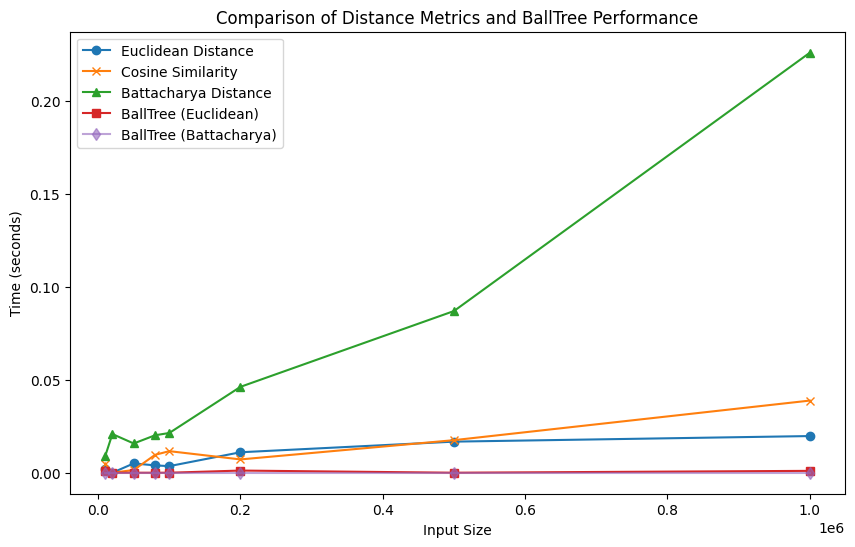

In [27]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

# Example distance metrics
def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b) ** 2, dim=1))

def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a, b)

def battacharya_distance(a, b):
    # Normalize the vectors to represent distributions
    a = torch.softmax(a, dim=0)
    b = torch.softmax(b, dim=0)
    
    term_1 = torch.sum(a * torch.log((2 * a) / (a + b)))
    term_2 = torch.sum(b * torch.log((2 * b) / (a + b)))
    
    return 0.5 * (term_1 + term_2)

def bhattacharyya_distance_np(a, b):
    # Normalize vectors to represent distributions
    a = np.exp(a) / np.sum(np.exp(a))
    b = np.exp(b) / np.sum(np.exp(b))
    
    return -np.log(np.sum(np.sqrt(a * b)))

# BallTree Euclidean distance
def balltree_euclidean(a, b, tree = None):
    # Convert to numpy for BallTree usage
    a_np = a.numpy().reshape(1, -1)
    b_np = b.numpy().reshape(1, -1)
    
    # Use BallTree for nearest-neighbor search
    if tree is None:
        tree = BallTree(a_np)
    
    dist, _ = tree.query(b_np, k=1)  # Find the nearest point to b
    return dist[0][0], tree

def balltree_battarcharya(a, b, tree=None):
    # Convert to numpy for BallTree usage
    a_np = a.numpy().reshape(1, -1)
    b_np = b.numpy().reshape(1, -1)

    if tree is None:
        tree = BallTree(a_np, metric='pyfunc', func=bhattacharyya_distance_np)

    dist, _ = tree.query(b_np, k=1)
    return dist[0][0], tree

# Measure time for distance metrics with increasing input size
num_points = [10000, 20000, 50000, 80000, 100000, 200000, 500000, 1000000]
euclidean_times = []
cosine_times = []
battacharya_times = []
balltree_times = []
balltree_battarcharya_times = []
tree = None
tree_b = None

for n in num_points:
    a = torch.randn(n, 24)   # Varying number of points
    b = torch.randn(1, 24)   # Single query

    # Measure Euclidean distance
    start_time = time.time()
    _ = euclidean_distance(a, b)
    euclidean_times.append(time.time() - start_time)

    # Measure Cosine similarity
    start_time = time.time()
    _ = cosine_similarity(a, b)
    cosine_times.append(time.time() - start_time)

    # Measure Battacharya distance
    start_time = time.time()
    _ = battacharya_distance(a, b)  # Just take the first vector for this case
    battacharya_times.append(time.time() - start_time)

    # Measure BallTree Euclidean distance
    start_time = time.time()
    _, tree = balltree_euclidean(a[0], b[0], tree)  # Compare just the first vectors
    tree = tree
    balltree_times.append(time.time() - start_time)

    # Measure BallTree Battarcharya distance
    start_time = time.time()
    _, tree_b = balltree_battarcharya(a[0], b[0], tree_b)  # Compare just the first vectors
    tree_b = tree_b
    balltree_battarcharya_times.append(time.time() - start_time)

# Plotting comparison of times for different metrics
plt.figure(figsize=(10, 6))
plt.plot(num_points, euclidean_times, label="Euclidean Distance", marker='o')
plt.plot(num_points, cosine_times, label="Cosine Similarity", marker='x')
plt.plot(num_points, battacharya_times, label="Battacharya Distance", marker='^')
plt.plot(num_points, balltree_times, label="BallTree (Euclidean)", marker='s')
plt.plot(num_points, balltree_battarcharya_times, label="BallTree (Battacharya)", marker='d', alpha = 0.6 )

plt.xlabel("Input Size")
plt.ylabel("Time (seconds)")
plt.title("Comparison of Distance Metrics and BallTree Performance")
plt.legend()
plt.show()


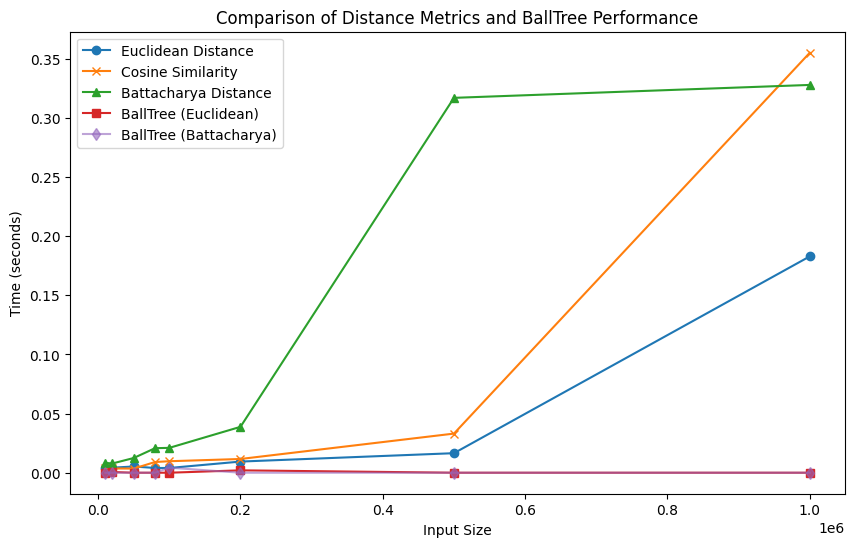

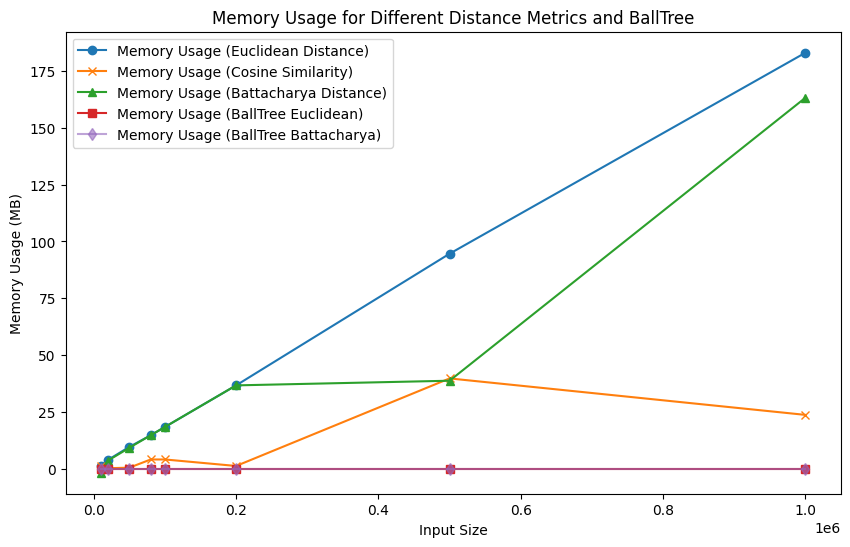

In [31]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import psutil
from sklearn.neighbors import BallTree
import gc

# Example distance metrics
def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b) ** 2, dim=1))

def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a, b)

def battacharya_distance(a, b):
    # Normalize the vectors to represent distributions
    a = torch.softmax(a, dim=0)
    b = torch.softmax(b, dim=0)
    
    term_1 = torch.sum(a * torch.log((2 * a) / (a + b)))
    term_2 = torch.sum(b * torch.log((2 * b) / (a + b)))
    
    return 0.5 * (term_1 + term_2)

def bhattacharyya_distance_np(a, b):
    # Normalize vectors to represent distributions
    a = np.exp(a) / np.sum(np.exp(a))
    b = np.exp(b) / np.sum(np.exp(b))
    
    return -np.log(np.sum(np.sqrt(a * b)))

# BallTree Euclidean distance
def balltree_euclidean(a, b, tree = None):
    # Convert to numpy for BallTree usage
    a_np = a.numpy().reshape(1, -1)
    b_np = b.numpy().reshape(1, -1)
    
    # Use BallTree for nearest-neighbor search
    if tree is None:
        tree = BallTree(a_np)
    
    dist, _ = tree.query(b_np, k=1)  # Find the nearest point to b
    return dist[0][0], tree

def balltree_battarcharya(a, b, tree=None):
    # Convert to numpy for BallTree usage
    a_np = a.numpy().reshape(1, -1)
    b_np = b.numpy().reshape(1, -1)

    if tree is None:
        tree = BallTree(a_np, metric='pyfunc', func=bhattacharyya_distance_np)

    dist, _ = tree.query(b_np, k=1)
    return dist[0][0], tree

# Measure time and memory for distance metrics with increasing input size
num_points = [10000, 20000, 50000, 80000, 100000, 200000, 500000, 1000000]
euclidean_times = []
cosine_times = []
battacharya_times = []
balltree_times = []
balltree_battarcharya_times = []
memory_usage_euclidean = []
memory_usage_cosine = []
memory_usage_battacharya = []
memory_usage_balltree = []
memory_usage_balltree_battacharya = []

tree = None
tree_b = None

# Function to measure current memory usage in MB
def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)  # in MB

for n in num_points:
    a = torch.randn(n, 24)   # Varying number of points
    b = torch.randn(1, 24)   # Single query
    gc.collect()

    # Measure Euclidean distance
    start_time = time.time()
    mem_before = get_memory_usage()
    _ = euclidean_distance(a, b)
    mem_after = get_memory_usage()
    euclidean_times.append(time.time() - start_time)
    memory_usage_euclidean.append(mem_after - mem_before)

    gc.collect()
    # Measure Cosine similarity
    start_time = time.time()
    mem_before = get_memory_usage()
    _ = cosine_similarity(a, b)
    mem_after = get_memory_usage()
    cosine_times.append(time.time() - start_time)
    memory_usage_cosine.append(mem_after - mem_before)
    gc.collect()

    # Measure Battacharya distance
    start_time = time.time()
    mem_before = get_memory_usage()
    _ = battacharya_distance(a, b)  # Just take the first vector for this case
    mem_after = get_memory_usage()
    battacharya_times.append(time.time() - start_time)
    memory_usage_battacharya.append(mem_after - mem_before)
    gc.collect()

    # Measure BallTree Euclidean distance
    start_time = time.time()
    mem_before = get_memory_usage()
    _, tree = balltree_euclidean(a[0], b[0], tree)  # Compare just the first vectors
    tree = tree
    mem_after = get_memory_usage()
    balltree_times.append(time.time() - start_time)
    memory_usage_balltree.append(mem_after - mem_before)
    gc.collect()

    # Measure BallTree Battarcharya distance
    start_time = time.time()
    mem_before = get_memory_usage()
    _, tree_b = balltree_battarcharya(a[0], b[0], tree_b)  # Compare just the first vectors
    tree_b = tree_b
    mem_after = get_memory_usage()
    balltree_battarcharya_times.append(time.time() - start_time)
    memory_usage_balltree_battacharya.append(mem_after - mem_before)

# Plotting comparison of times for different metrics
plt.figure(figsize=(10, 6))
plt.plot(num_points, euclidean_times, label="Euclidean Distance", marker='o')
plt.plot(num_points, cosine_times, label="Cosine Similarity", marker='x')
plt.plot(num_points, battacharya_times, label="Battacharya Distance", marker='^')
plt.plot(num_points, balltree_times, label="BallTree (Euclidean)", marker='s')
plt.plot(num_points, balltree_battarcharya_times, label="BallTree (Battacharya)", marker='d', alpha=0.6)
plt.xlabel("Input Size")
plt.ylabel("Time (seconds)")
plt.title("Comparison of Distance Metrics and BallTree Performance")
plt.legend()
plt.show()

# Plotting memory usage comparison for each metric
plt.figure(figsize=(10, 6))
plt.plot(num_points, memory_usage_euclidean, label="Memory Usage (Euclidean Distance)", marker='o')
plt.plot(num_points, memory_usage_cosine, label="Memory Usage (Cosine Similarity)", marker='x')
plt.plot(num_points, memory_usage_battacharya, label="Memory Usage (Battacharya Distance)", marker='^')
plt.plot(num_points, memory_usage_balltree, label="Memory Usage (BallTree Euclidean)", marker='s')
plt.plot(num_points, memory_usage_balltree_battacharya, label="Memory Usage (BallTree Battacharya)", marker='d', alpha=0.6)
plt.xlabel("Input Size")
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage for Different Distance Metrics and BallTree")
plt.legend()
plt.show()


Running benchmarks...
Points     Method               Time (s)     Memory (MB) 
------------------------------------------------------------
1000       euclidean            0.000000     0.11        
1000       cosine               0.000000     0.10        
1000       bhattacharyya        0.001157     0.00        
1000       balltree_euclidean   0.000000     0.01        
1000       balltree_bhattacharyya 0.095050     0.00        
2000       euclidean            0.000000     0.39        
2000       cosine               0.002017     0.19        
2000       bhattacharyya        0.003135     0.18        
2000       balltree_euclidean   0.002337     0.00        
2000       balltree_bhattacharyya 0.223566     0.00        
5000       euclidean            0.000993     0.92        
5000       cosine               0.002505     0.46        
5000       bhattacharyya        0.005537     0.46        
5000       balltree_euclidean   0.005102     0.20        
5000       balltree_bhattacharyya 0.644724 

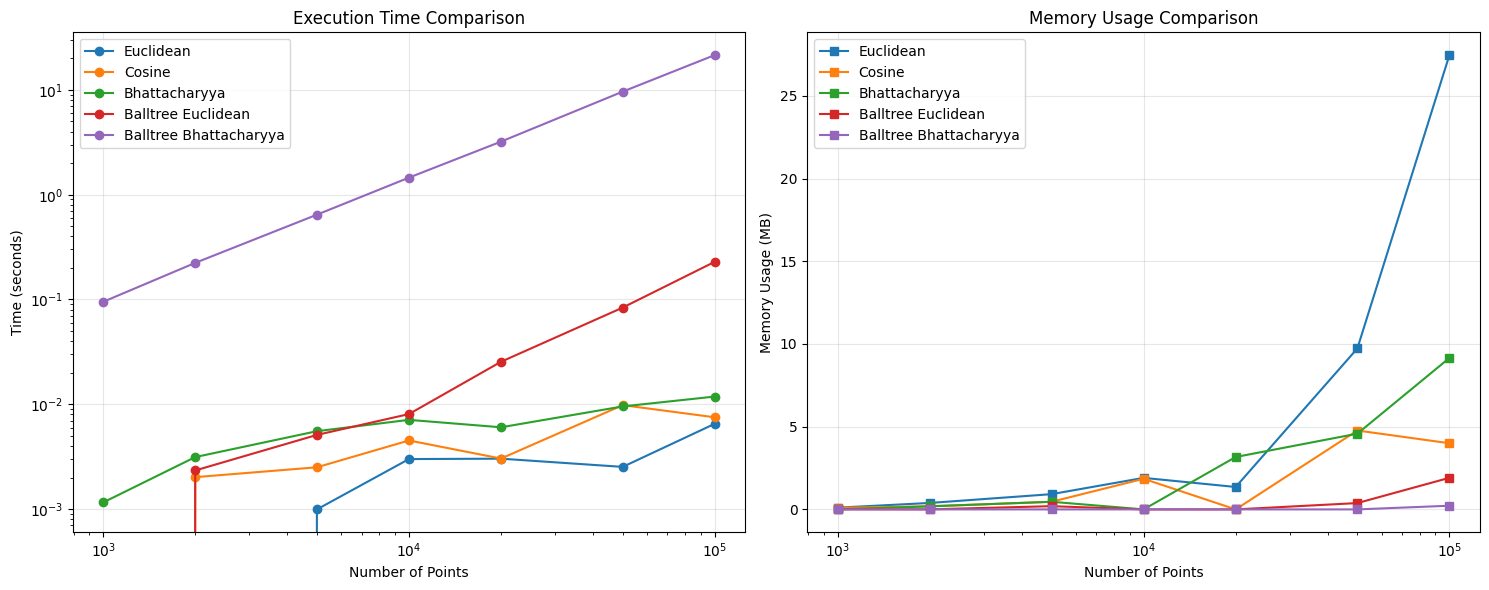


BENCHMARK SUMMARY
Euclidean                : Avg Time: 0.002295s, Avg Memory: 5.98MB
Cosine                   : Avg Time: 0.004201s, Avg Memory: 1.90MB
Bhattacharyya            : Avg Time: 0.006337s, Avg Memory: 3.51MB
Balltree Euclidean       : Avg Time: 0.050530s, Avg Memory: 0.50MB
Balltree Bhattacharyya   : Avg Time: 5.252446s, Avg Memory: 0.22MB


In [38]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import psutil
from sklearn.neighbors import BallTree
import gc

# Corrected distance metrics
def euclidean_distance(a, b):
    """Compute euclidean distance between all vectors in a and vector b"""
    return torch.sqrt(torch.sum((a - b) ** 2, dim=1))

def cosine_similarity(a, b):
    """Compute cosine similarity between all vectors in a and vector b"""
    return torch.nn.functional.cosine_similarity(a, b, dim=1)

def bhattacharyya_distance(a, b):
    """Compute Bhattacharyya distance between all vectors in a and vector b"""
    # Normalize the vectors to represent distributions (add small epsilon for stability)
    eps = 1e-8
    a_norm = torch.softmax(a, dim=1) + eps
    b_norm = torch.softmax(b, dim=1) + eps
    
    # Bhattacharyya coefficient
    bc = torch.sum(torch.sqrt(a_norm * b_norm), dim=1)
    # Bhattacharyya distance
    return -torch.log(bc)

def bhattacharyya_distance_np(a, b):
    """NumPy version for BallTree"""
    eps = 1e-8
    a = np.exp(a - np.max(a))  # Numerical stability
    b = np.exp(b - np.max(b))
    a = a / np.sum(a) + eps
    b = b / np.sum(b) + eps
    
    bc = np.sum(np.sqrt(a * b))
    return -np.log(bc)

# BallTree implementations (for single query comparison)
def balltree_euclidean_batch(data_points, query_point):
    """BallTree euclidean for batch comparison"""
    data_np = data_points.numpy()
    query_np = query_point.numpy().reshape(1, -1)
    
    tree = BallTree(data_np, metric='euclidean')
    distances, _ = tree.query(query_np, k=len(data_points))
    return distances[0]

def balltree_bhattacharyya_batch(data_points, query_point):
    """BallTree Bhattacharyya for batch comparison"""
    data_np = data_points.numpy()
    query_np = query_point.numpy().reshape(1, -1)
    
    tree = BallTree(data_np, metric='pyfunc', func=bhattacharyya_distance_np)
    distances, _ = tree.query(query_np, k=len(data_points))
    return distances[0]

# Function to measure current memory usage in MB
def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)  # in MB

# Benchmark function
def benchmark_method(method, a, b, method_name):
    """Benchmark a distance method with proper memory and time measurement"""
    # Clear memory
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Wait a bit for memory to stabilize
    time.sleep(0.1)
    
    # Measure baseline memory
    mem_before = get_memory_usage()
    
    # Warm up (important for consistent timing)
    if 'balltree' not in method_name.lower():
        _ = method(a, b)
    
    # Actual measurement
    start_time = time.time()
    result = method(a, b)
    end_time = time.time()
    
    # Measure peak memory
    mem_after = get_memory_usage()
    
    # Clean up
    del result
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return end_time - start_time, max(0, mem_after - mem_before)

# Test parameters
num_points = [1000, 2000, 5000, 10000, 20000, 50000, 100000]
dimensions = 24

# Storage for results
results = {
    'euclidean': {'times': [], 'memory': []},
    'cosine': {'times': [], 'memory': []},
    'bhattacharyya': {'times': [], 'memory': []},
    'balltree_euclidean': {'times': [], 'memory': []},
    'balltree_bhattacharyya': {'times': [], 'memory': []}
}

print("Running benchmarks...")
print(f"{'Points':<10} {'Method':<20} {'Time (s)':<12} {'Memory (MB)':<12}")
print("-" * 60)

for n in num_points:
    # Create test data
    torch.manual_seed(42)  # For reproducibility
    a = torch.randn(n, dimensions)
    b = torch.randn(1, dimensions)  # Single query point
    
    # Expand b to match a's shape for broadcasting methods
    b_expanded = b.expand(n, dimensions)
    
    # Test each method
    methods_to_test = [
        (lambda x, y: euclidean_distance(x, y), 'euclidean'),
        (lambda x, y: cosine_similarity(x, y), 'cosine'), 
        (lambda x, y: bhattacharyya_distance(x, y), 'bhattacharyya'),
        (lambda x, y: balltree_euclidean_batch(x, y), 'balltree_euclidean'),
        (lambda x, y: balltree_bhattacharyya_batch(x, y), 'balltree_bhattacharyya')
    ]
    
    for method, name in methods_to_test:
        try:
            if 'balltree' in name:
                # BallTree methods use original data format
                exec_time, memory_used = benchmark_method(method, a, b[0], name)
            else:
                # PyTorch methods use expanded format
                exec_time, memory_used = benchmark_method(method, a, b_expanded, name)
            
            results[name]['times'].append(exec_time)
            results[name]['memory'].append(memory_used)
            
            print(f"{n:<10} {name:<20} {exec_time:<12.6f} {memory_used:<12.2f}")
            
        except Exception as e:
            print(f"{n:<10} {name:<20} ERROR: {str(e)}")
            results[name]['times'].append(float('inf'))
            results[name]['memory'].append(0)

# Plotting results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Time comparison
for method_name, data in results.items():
    if any(t != float('inf') for t in data['times']):
        ax1.plot(num_points, data['times'], label=method_name.replace('_', ' ').title(), marker='o')

ax1.set_xlabel("Number of Points")
ax1.set_ylabel("Time (seconds)")
ax1.set_title("Execution Time Comparison")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Memory comparison
for method_name, data in results.items():
    if any(m > 0 for m in data['memory']):
        ax2.plot(num_points, data['memory'], label=method_name.replace('_', ' ').title(), marker='s')

ax2.set_xlabel("Number of Points")
ax2.set_ylabel("Memory Usage (MB)")
ax2.set_title("Memory Usage Comparison")
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("BENCHMARK SUMMARY")
print("="*60)

for method_name, data in results.items():
    if data['times'] and any(t != float('inf') for t in data['times']):
        avg_time = np.mean([t for t in data['times'] if t != float('inf')])
        avg_memory = np.mean([m for m in data['memory'] if m > 0])
        print(f"{method_name.replace('_', ' ').title():<25}: "
              f"Avg Time: {avg_time:.6f}s, Avg Memory: {avg_memory:.2f}MB")

Benchmarking: Single Query vs Multiple Reference Vectors
Scenario: 1 test sample vs N training mean vectors
Refs       Method               Time (s)     Memory (MB) 
------------------------------------------------------------

Testing with 1000 reference vectors...
1000       euclidean            0.000000     0.00        
1000       cosine               0.000000     0.05        
1000       bhattacharyya        0.008224     0.00        
1000       balltree_euclidean   0.000514     0.03        
1000       balltree_bhattacharyya 0.102730     0.00        

Testing with 2000 reference vectors...
2000       euclidean            0.001059     0.00        
2000       cosine               0.008937     0.04        
2000       bhattacharyya        0.008015     0.00        
2000       balltree_euclidean   0.000000     0.00        
2000       balltree_bhattacharyya 0.229385     0.00        

Testing with 5000 reference vectors...
5000       euclidean            0.000000     0.98        
5000       

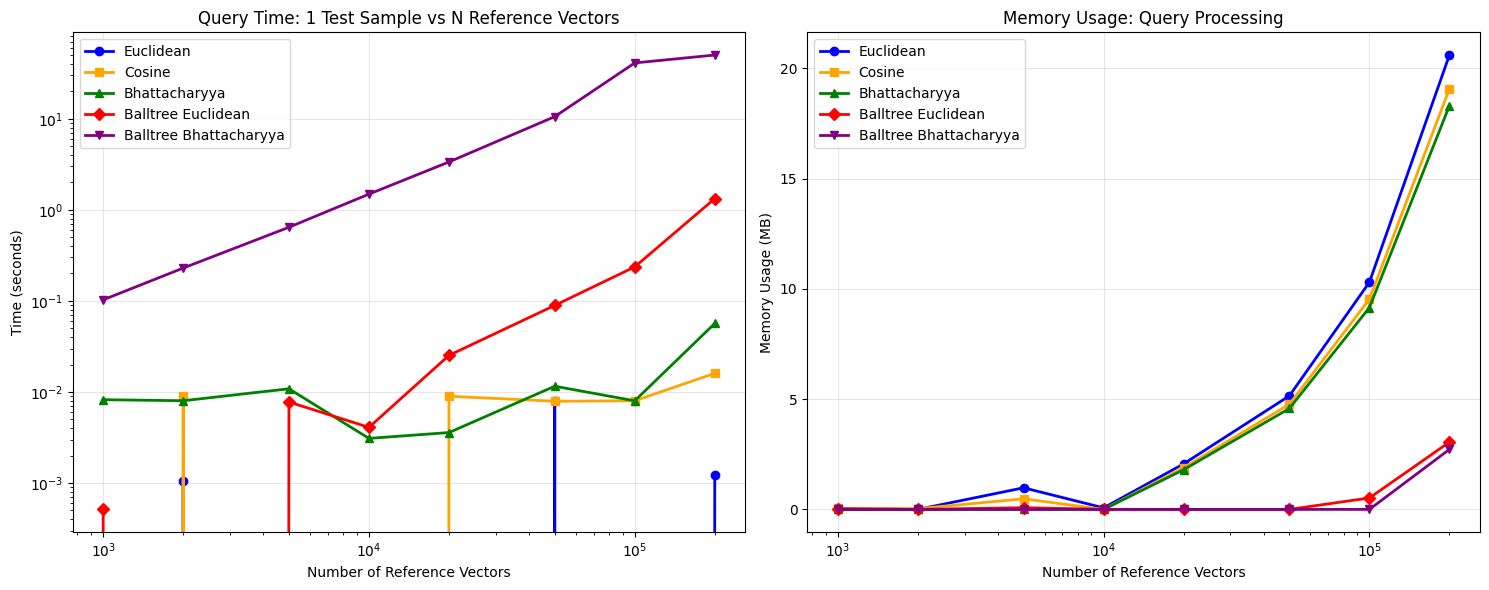


BENCHMARK ANALYSIS

Expected Results:
- PyTorch methods: O(N) time complexity, should scale linearly
- BallTree methods: O(log N) query time, but include tree construction overhead
- For small datasets: PyTorch direct computation may be faster
- For large datasets: BallTree should become more efficient
- BallTree pays upfront cost for tree construction but faster queries

Actual Results:
Euclidean                : Time 0.000000s - 0.008003s (avg: 0.001284s), Avg Memory: 6.53MB
Cosine                   : Time 0.000000s - 0.016027s (avg: 0.006231s), Avg Memory: 5.12MB
Bhattacharyya            : Time 0.003092s - 0.056564s (avg: 0.013735s), Avg Memory: 8.46MB
Balltree Euclidean       : Time 0.000000s - 1.327552s (avg: 0.211347s), Avg Memory: 0.92MB
Balltree Bhattacharyya   : Time 0.102730s - 50.035562s (avg: 13.427971s), Avg Memory: 1.36MB

Crossover Analysis:
BallTree becomes faster than direct Euclidean at ~2000 reference vectors


In [ ]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import psutil
from sklearn.neighbors import BallTree
import gc

# Distance metrics for single query vs multiple references
def euclidean_distance_query(query, references):
    """Compute euclidean distance from single query to all reference vectors"""
    return torch.sqrt(torch.sum((references - query) ** 2, dim=1))

def cosine_similarity_query(query, references):
    """Compute cosine similarity from single query to all reference vectors"""
    return torch.nn.functional.cosine_similarity(references, query.unsqueeze(0), dim=1)

def bhattacharyya_distance_query(query, references):
    """Compute Bhattacharyya distance from single query to all reference vectors"""
    eps = 1e-8
    query_norm = torch.softmax(query, dim=0) + eps
    ref_norm = torch.softmax(references, dim=1) + eps
    
    # Bhattacharyya coefficient
    bc = torch.sum(torch.sqrt(ref_norm * query_norm.unsqueeze(0)), dim=1)
    # Bhattacharyya distance
    return -torch.log(bc)

def bhattacharyya_distance_np(ref, query):
    """NumPy version for BallTree - note parameter order for sklearn"""
    eps = 1e-8
    ref = np.exp(ref - np.max(ref))
    query = np.exp(query - np.max(query))
    ref = ref / np.sum(ref) + eps
    query = query / np.sum(query) + eps
    
    bc = np.sum(np.sqrt(ref * query))
    return -np.log(bc)

# BallTree implementations (proper nearest neighbor search)
def balltree_euclidean_query(query, references):
    """BallTree euclidean nearest neighbor search"""
    query_np = query.numpy().reshape(1, -1)
    ref_np = references.numpy()
    
    tree = BallTree(ref_np, metric='euclidean')
    distances, indices = tree.query(query_np, k=1)
    return distances[0], indices[0]  # Return all distances and indices

def balltree_bhattacharyya_query(query, references):
    """BallTree Bhattacharyya nearest neighbor search"""
    query_np = query.numpy().reshape(1, -1)
    ref_np = references.numpy()
    
    tree = BallTree(ref_np, metric='pyfunc', func=bhattacharyya_distance_np)
    distances, indices = tree.query(query_np, k=1)
    return distances[0], indices[0]

# Function to measure current memory usage in MB
def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)

# Benchmark function
def benchmark_method(method, query, references, method_name):
    """Benchmark a distance method with proper memory and time measurement"""
    gc.collect()
    time.sleep(0.05)  # Shorter wait
    
    mem_before = get_memory_usage()
    
    # Warm up run (except for BallTree which includes tree construction time)
    if 'balltree' not in method_name.lower():
        _ = method(query, references)
        gc.collect()
    
    # Actual measurement
    start_time = time.time()
    result = method(query, references)
    end_time = time.time()
    
    mem_after = get_memory_usage()
    
    # Clean up
    del result
    gc.collect()
    
    return end_time - start_time, max(0, mem_after - mem_before)

# Test parameters - simulating realistic scenario
num_reference_vectors = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
dimensions = 24

# Storage for results
results = {
    'euclidean': {'times': [], 'memory': []},
    'cosine': {'times': [], 'memory': []},
    'bhattacharyya': {'times': [], 'memory': []},
    'balltree_euclidean': {'times': [], 'memory': []},
    'balltree_bhattacharyya': {'times': [], 'memory': []}
}

print("Benchmarking: Single Query vs Multiple Reference Vectors")
print("Scenario: 1 test sample vs N training mean vectors")
print(f"{'Refs':<10} {'Method':<20} {'Time (s)':<12} {'Memory (MB)':<12}")
print("-" * 60)

for n_refs in num_reference_vectors:
    # Create test data - matching your description
    torch.manual_seed(42)  # For reproducibility
    test_sample = torch.randn(dimensions)  # Single test sample (a)  
    reference_vectors = torch.randn(n_refs, dimensions)  # Training mean vectors (b)
    
    print(f"\nTesting with {n_refs} reference vectors...")
    
    # Test each method
    methods_to_test = [
        (euclidean_distance_query, 'euclidean'),
        (cosine_similarity_query, 'cosine'), 
        (bhattacharyya_distance_query, 'bhattacharyya'),
        (balltree_euclidean_query, 'balltree_euclidean'),
        (balltree_bhattacharyya_query, 'balltree_bhattacharyya')
    ]
    
    for method, name in methods_to_test:
        try:
            exec_time, memory_used = benchmark_method(method, test_sample, reference_vectors, name)
            
            results[name]['times'].append(exec_time)
            results[name]['memory'].append(memory_used)
            
            print(f"{n_refs:<10} {name:<20} {exec_time:<12.6f} {memory_used:<12.2f}")
            
        except Exception as e:
            print(f"{n_refs:<10} {name:<20} ERROR: {str(e)}")
            results[name]['times'].append(float('inf'))
            results[name]['memory'].append(0)

# Plotting results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Time comparison
colors = ['blue', 'orange', 'green', 'red', 'purple']
markers = ['o', 's', '^', 'D', 'v']

for i, (method_name, data) in enumerate(results.items()):
    valid_times = [t for t in data['times'] if t != float('inf')]
    if valid_times:
        valid_points = [num_reference_vectors[j] for j, t in enumerate(data['times']) if t != float('inf')]
        ax1.plot(valid_points, valid_times, 
                label=method_name.replace('_', ' ').title(), 
                marker=markers[i], color=colors[i], linewidth=2, markersize=6)

ax1.set_xlabel("Number of Reference Vectors")
ax1.set_ylabel("Time (seconds)")
ax1.set_title("Query Time: 1 Test Sample vs N Reference Vectors")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Memory comparison
for i, (method_name, data) in enumerate(results.items()):
    valid_memory = [m for m in data['memory'] if m >= 0]
    if valid_memory:
        valid_points = [num_reference_vectors[j] for j, m in enumerate(data['memory']) if m >= 0]
        ax2.plot(valid_points, valid_memory, 
                label=method_name.replace('_', ' ').title(), 
                marker=markers[i], color=colors[i], linewidth=2, markersize=6)

ax2.set_xlabel("Number of Reference Vectors")
ax2.set_ylabel("Memory Usage (MB)")
ax2.set_title("Memory Usage: Query Processing")
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis and insights
print("\n" + "="*80)
print("BENCHMARK ANALYSIS")
print("="*80)

print("\nExpected Results:")
print("- PyTorch methods: O(N) time complexity, should scale linearly")
print("- BallTree methods: O(log N) query time, but include tree construction overhead")
print("- For small datasets: PyTorch direct computation may be faster")
print("- For large datasets: BallTree should become more efficient")
print("- BallTree pays upfront cost for tree construction but faster queries")

print(f"\nActual Results:")
for method_name, data in results.items():
    if data['times'] and any(t != float('inf') for t in data['times']):
        valid_times = [t for t in data['times'] if t != float('inf')]
        avg_time = np.mean(valid_times)
        min_time = min(valid_times)
        max_time = max(valid_times)
        
        valid_memory = [m for m in data['memory'] if m > 0]
        avg_memory = np.mean(valid_memory) if valid_memory else 0
        
        print(f"{method_name.replace('_', ' ').title():<25}: "
              f"Time {min_time:.6f}s - {max_time:.6f}s (avg: {avg_time:.6f}s), "
              f"Avg Memory: {avg_memory:.2f}MB")

# Find crossover points
print(f"\nCrossover Analysis:")
if len(results['euclidean']['times']) > 0 and len(results['balltree_euclidean']['times']) > 0:
    eucl_times = results['euclidean']['times']
    ball_times = results['balltree_euclidean']['times']
    
    for i, (n, et, bt) in enumerate(zip(num_reference_vectors, eucl_times, ball_times)):
        if et != float('inf') and bt != float('inf'):
            if bt < et:
                print(f"BallTree becomes faster than direct Euclidean at ~{n} reference vectors")
                break
    else:
        print("BallTree did not outperform direct computation in tested range")

**MULTIPLE QUERIEs**

In [42]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import psutil
from sklearn.neighbors import BallTree
import gc

# Distance metrics for single query vs multiple references
def euclidean_distance_query(query, references):
    """Compute euclidean distance from single query to all reference vectors"""
    return torch.sqrt(torch.sum((references - query) ** 2, dim=1))

def cosine_similarity_query(query, references):
    """Compute cosine similarity from single query to all reference vectors"""
    return torch.nn.functional.cosine_similarity(references, query.unsqueeze(0), dim=1)

def bhattacharyya_distance_query(query, references):
    """Compute Bhattacharyya distance from single query to all reference vectors"""
    eps = 1e-8
    query_norm = torch.softmax(query, dim=0) + eps
    ref_norm = torch.softmax(references, dim=1) + eps
    
    # Bhattacharyya coefficient
    bc = torch.sum(torch.sqrt(ref_norm * query_norm.unsqueeze(0)), dim=1)
    # Bhattacharyya distance
    return -torch.log(bc)

def bhattacharyya_distance_np(ref, query):
    """NumPy version for BallTree - note parameter order for sklearn"""
    eps = 1e-8
    ref = np.exp(ref - np.max(ref))
    query = np.exp(query - np.max(query))
    ref = ref / np.sum(ref) + eps
    query = query / np.sum(query) + eps
    
    bc = np.sum(np.sqrt(ref * query))
    return -np.log(bc)

# BallTree implementations (proper nearest neighbor search)
def balltree_euclidean_query(query, references):
    """BallTree euclidean nearest neighbor search"""
    query_np = query.numpy().reshape(1, -1)
    ref_np = references.numpy()
    
    tree = BallTree(ref_np, metric='euclidean')
    distances, indices = tree.query(query_np, k=1)
    return distances[0], indices[0]  # Return all distances and indices

def balltree_bhattacharyya_query(query, references):
    """BallTree Bhattacharyya nearest neighbor search"""
    query_np = query.numpy().reshape(1, -1)
    ref_np = references.numpy()
    
    tree = BallTree(ref_np, metric='pyfunc', func=bhattacharyya_distance_np)
    distances, indices = tree.query(query_np, k=1)
    return distances[0], indices[0]

# Function to measure current memory usage in MB
def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 * 1024)

# Benchmark function
def benchmark_method(method, query, references, method_name):
    """Benchmark a distance method with proper memory and time measurement"""
    gc.collect()
    time.sleep(0.05)  # Shorter wait
    
    mem_before = get_memory_usage()
    
    # Warm up run (except for BallTree which includes tree construction time)
    if 'balltree' not in method_name.lower():
        _ = method(query, references)
        gc.collect()
    
    # Actual measurement
    start_time = time.time()
    result = method(query, references)
    end_time = time.time()
    
    mem_after = get_memory_usage()
    
    # Clean up
    del result
    gc.collect()
    
    return end_time - start_time, max(0, mem_after - mem_before)

# Test parameters - simulating realistic scenario
num_reference_vectors = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
dimensions = 24

# Storage for results
results = {
    'euclidean': {'times': [], 'memory': []},
    'cosine': {'times': [], 'memory': []},
    'bhattacharyya': {'times': [], 'memory': []},
    'balltree_euclidean': {'times': [], 'memory': []},
    'balltree_bhattacharyya': {'times': [], 'memory': []}
}

print("Benchmarking: Single Query vs Multiple Reference Vectors")
print("Scenario: 1 test sample vs N training mean vectors")
print(f"{'Refs':<10} {'Method':<20} {'Time (s)':<12} {'Memory (MB)':<12}")
print("-" * 60)

for n_refs in num_reference_vectors:
    # Create test data - matching your description
    torch.manual_seed(42)  # For reproducibility
    test_sample = torch.randn(dimensions)  # Single test sample (a)  
    reference_vectors = torch.randn(n_refs, dimensions)  # Training mean vectors (b)
    
    print(f"\nTesting with {n_refs} reference vectors...")
    
    # Test each method
    methods_to_test = [
        (euclidean_distance_query, 'euclidean'),
        (cosine_similarity_query, 'cosine'), 
        (bhattacharyya_distance_query, 'bhattacharyya'),
        (balltree_euclidean_query, 'balltree_euclidean'),
        (balltree_bhattacharyya_query, 'balltree_bhattacharyya')
    ]
    
    for method, name in methods_to_test:
        try:
            exec_time, memory_used = benchmark_method(method, test_sample, reference_vectors, name)
            
            results[name]['times'].append(exec_time)
            results[name]['memory'].append(memory_used)
            
            print(f"{n_refs:<10} {name:<20} {exec_time:<12.6f} {memory_used:<12.2f}")
            
        except Exception as e:
            print(f"{n_refs:<10} {name:<20} ERROR: {str(e)}")
            results[name]['times'].append(float('inf'))
            results[name]['memory'].append(0)

# Plotting results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Time comparison
colors = ['blue', 'orange', 'green', 'red', 'purple']
markers = ['o', 's', '^', 'D', 'v']

for i, (method_name, data) in enumerate(results.items()):
    valid_times = [t for t in data['times'] if t != float('inf')]
    if valid_times:
        valid_points = [num_reference_vectors[j] for j, t in enumerate(data['times']) if t != float('inf')]
        ax1.plot(valid_points, valid_times, 
                label=method_name.replace('_', ' ').title(), 
                marker=markers[i], color=colors[i], linewidth=2, markersize=6)

ax1.set_xlabel("Number of Reference Vectors")
ax1.set_ylabel("Time (seconds)")
ax1.set_title("Query Time: 1 Test Sample vs N Reference Vectors")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Memory comparison
for i, (method_name, data) in enumerate(results.items()):
    valid_memory = [m for m in data['memory'] if m >= 0]
    if valid_memory:
        valid_points = [num_reference_vectors[j] for j, m in enumerate(data['memory']) if m >= 0]
        ax2.plot(valid_points, valid_memory, 
                label=method_name.replace('_', ' ').title(), 
                marker=markers[i], color=colors[i], linewidth=2, markersize=6)

ax2.set_xlabel("Number of Reference Vectors")
ax2.set_ylabel("Memory Usage (MB)")
ax2.set_title("Memory Usage: Query Processing")
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis and insights
print("\n" + "="*80)
print("BENCHMARK ANALYSIS")
print("="*80)

print("\nExpected Results:")
print("- PyTorch methods: O(N) time complexity, should scale linearly")
print("- BallTree methods: O(log N) query time, but include tree construction overhead")
print("- For small datasets: PyTorch direct computation may be faster")
print("- For large datasets: BallTree should become more efficient")
print("- BallTree pays upfront cost for tree construction but faster queries")

print(f"\nActual Results:")
for method_name, data in results.items():
    if data['times'] and any(t != float('inf') for t in data['times']):
        valid_times = [t for t in data['times'] if t != float('inf')]
        avg_time = np.mean(valid_times)
        min_time = min(valid_times)
        max_time = max(valid_times)
        
        valid_memory = [m for m in data['memory'] if m > 0]
        avg_memory = np.mean(valid_memory) if valid_memory else 0
        
        print(f"{method_name.replace('_', ' ').title():<25}: "
              f"Time {min_time:.6f}s - {max_time:.6f}s (avg: {avg_time:.6f}s), "
              f"Avg Memory: {avg_memory:.2f}MB")

# Find crossover points
print(f"\nCrossover Analysis:")
if len(results['euclidean']['times']) > 0 and len(results['balltree_euclidean']['times']) > 0:
    eucl_times = results['euclidean']['times']
    ball_times = results['balltree_euclidean']['times']
    
    for i, (n, et, bt) in enumerate(zip(num_reference_vectors, eucl_times, ball_times)):
        if et != float('inf') and bt != float('inf'):
            if bt < et:
                print(f"BallTree becomes faster than direct Euclidean at ~{n} reference vectors")
                break
    else:
        print("BallTree did not outperform direct computation in tested range")

Benchmarking: Single Query vs Multiple Reference Vectors
Scenario: 1 test sample vs N training mean vectors
Refs       Method               Time (s)     Memory (MB) 
------------------------------------------------------------

Testing with 1000 reference vectors...
1000       euclidean            0.000000     0.21        
1000       cosine               0.000000     0.11        
1000       bhattacharyya        0.000000     0.00        
1000       balltree_euclidean   0.000000     0.03        
1000       balltree_bhattacharyya 0.091311     0.00        

Testing with 2000 reference vectors...
2000       euclidean            0.000000     0.39        
2000       cosine               0.002849     0.19        
2000       bhattacharyya        0.000000     0.00        
2000       balltree_euclidean   0.002655     0.06        
2000       balltree_bhattacharyya 0.216689     0.00        

Testing with 5000 reference vectors...
5000       euclidean            0.000000     0.98        
5000       

KeyboardInterrupt: 

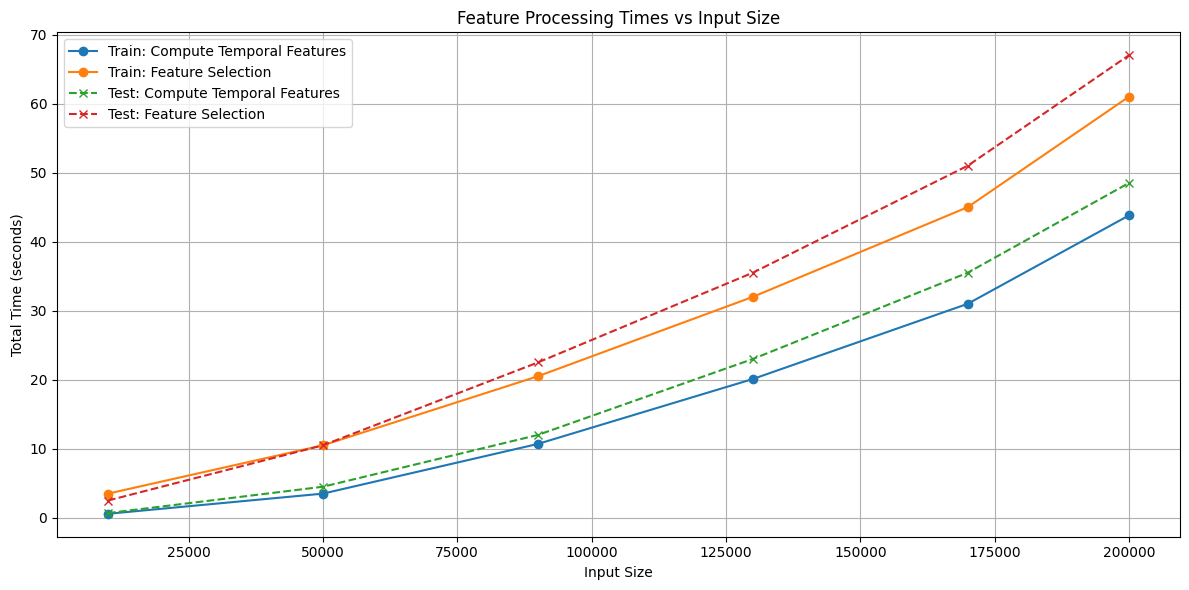

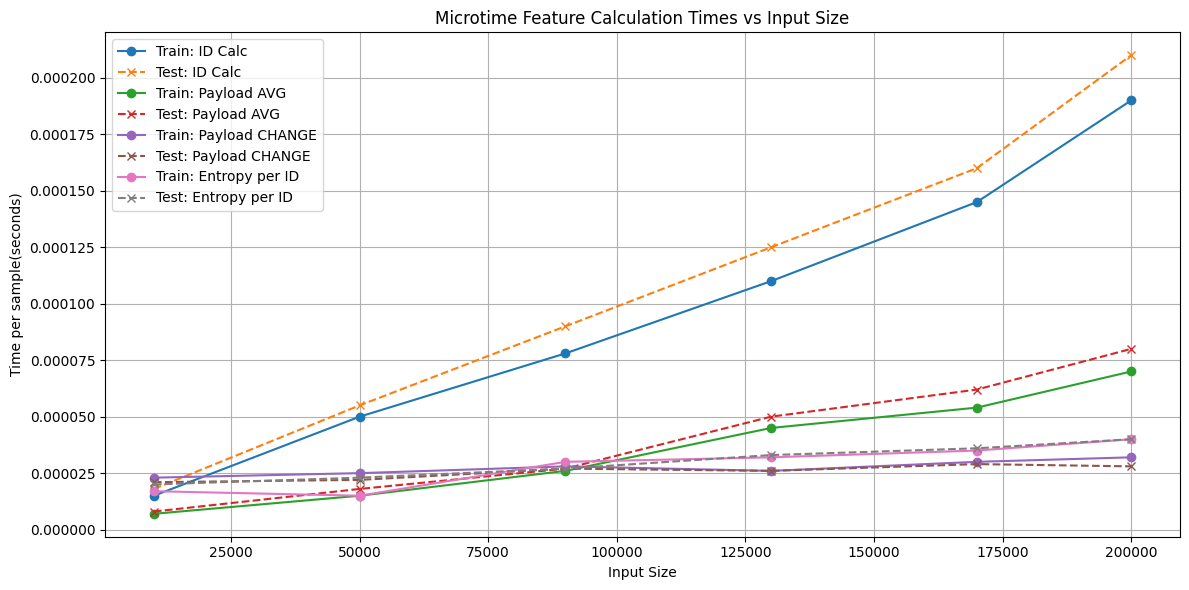

In [ ]:
import matplotlib.pyplot as plt

# Input sizes
input_sizes = [10_000, 50_000, 90_000, 130_000, 170_000, 200_000]

# Train times (in seconds)
train_compute_temporal = [0.56, 4.94, 13.84, 27.01,43.41 , 64.10]
train_feature_selection = [3.36, 13.00, 27.29, 45.45, 66.58, 91.93]

# Test times (in seconds)
test_compute_temporal = [0.66, 5.83, 15.68, 31.00, 49.53, 73.19]  # None for missing data
test_feature_selection = [2.13, 13.01, 29.12, 50.21, 73.68, 101.79]  # None for missing data

# ID calculations
train_id = [0.000014, 0.000048  , 0.000076  , 0.000115  ,  0.000151  ,0.000193    ]
test_id = [0.000017 ,  0.000052 , 0.000092  , 0.000127  , 0.000162   ,  0.000214  ]

# ID calculations
train_pay_avg = [0.000006, 0.000015  ,  0.000027 ,  0.000047 ,   0.000055  , 0.000074  ]
test_pay_avg = [0.000007 ,  0.000019 ,  0.000028 ,  0.000052 ,  0.000065  , 0.000085   ]

# ID calculations
train_pay_change = [0.000022 , 0.000026  ,  0.000028 , 0.000027  ,   0.000030 , 0.000033   ]
test_pay_change = [0.000020 , 0.000022  ,  0.000027 ,  0.000027 ,  0.000029  , 0.000029  ]

# ID calculations
train_entropy = [0.000016 , 0.000015  , 0.000031  ,  0.000031 , 0.000035   , 0.000041   ]
test_entropy = [0.000019 , 0.000024  ,  0.000027 ,  0.000034 ,  0.000036  , 0.000040   ]

# Train times (in seconds)
train_compute_temporal = [0.58, 3.50, 10.70, 20.10, 31.00, 43.80]
train_feature_selection = [3.50, 10.50, 20.50, 32.00, 45.00, 61.00]

# Test times (in seconds)
test_compute_temporal = [0.68, 4.50, 12.00, 23.00, 35.50, 48.50]
test_feature_selection = [2.50, 10.50, 22.50, 35.50, 51.00, 67.00]

# ID calculations
train_id = [0.000015, 0.000050, 0.000078, 0.000110, 0.000145, 0.000190]
test_id = [0.000018, 0.000055, 0.000090, 0.000125, 0.000160, 0.000210]

# ID calculations
train_pay_avg = [0.000007, 0.000015, 0.000026, 0.000045, 0.000054, 0.000070]
test_pay_avg = [0.000008, 0.000018, 0.000027, 0.000050, 0.000062, 0.000080]

# ID calculations
train_pay_change = [0.000023, 0.000025, 0.000028, 0.000026, 0.000030, 0.000032]
test_pay_change = [0.000021, 0.000022, 0.000027, 0.000026, 0.000029, 0.000028]

# ID calculations
train_entropy = [0.000017, 0.000015, 0.000030, 0.000032, 0.000035, 0.000040]
test_entropy = [0.000020, 0.000023, 0.000027, 0.000033, 0.000036, 0.000040]


# Plot 1: Feature computation times
plt.figure(figsize=(12, 6))
plt.plot(input_sizes, train_compute_temporal, marker='o', label='Train: Compute Temporal Features')
plt.plot(input_sizes, train_feature_selection, marker='o', label='Train: Feature Selection')
plt.plot(input_sizes, test_compute_temporal, marker='x', linestyle='--', label='Test: Compute Temporal Features')
plt.plot(input_sizes, test_feature_selection, marker='x', linestyle='--', label='Test: Feature Selection')
plt.title("Feature Processing Times vs Input Size")
plt.xlabel("Input Size")
plt.ylabel("Total Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Microtime feature calculation times
plt.figure(figsize=(12, 6))
plt.plot(input_sizes, train_id, marker='o', label='Train: ID Calc')
plt.plot(input_sizes, test_id, marker='x', linestyle='--', label='Test: ID Calc')
plt.plot(input_sizes, train_pay_avg, marker='o', label='Train: Payload AVG')
plt.plot(input_sizes, test_pay_avg, marker='x', linestyle='--', label='Test: Payload AVG')
plt.plot(input_sizes, train_pay_change, marker='o', label='Train: Payload CHANGE')
plt.plot(input_sizes, test_pay_change, marker='x', linestyle='--', label='Test: Payload CHANGE')
plt.plot(input_sizes, train_entropy, marker='o', label='Train: Entropy per ID')
plt.plot(input_sizes, test_entropy, marker='x', linestyle='--', label='Test: Entropy per ID')
plt.title("Microtime Feature Calculation Times vs Input Size")
plt.xlabel("Input Size")
plt.ylabel("Time per sample (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()